scale_pos_weight ≈ 19.01 (neg=6937, pos=365)
model XGBoost — Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1388
           1       1.00      1.00      1.00        73

    accuracy                           1.00      1461
   macro avg       1.00      1.00      1.00      1461
weighted avg       1.00      1.00      1.00      1461



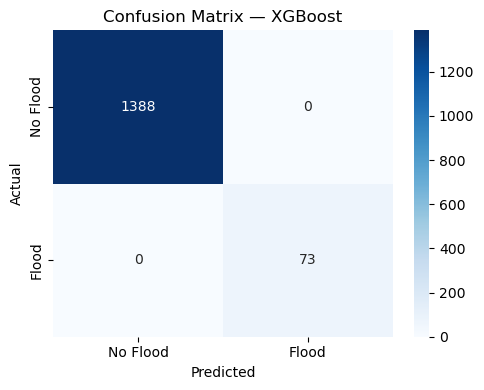

ROC-AUC (XGB): 1.000


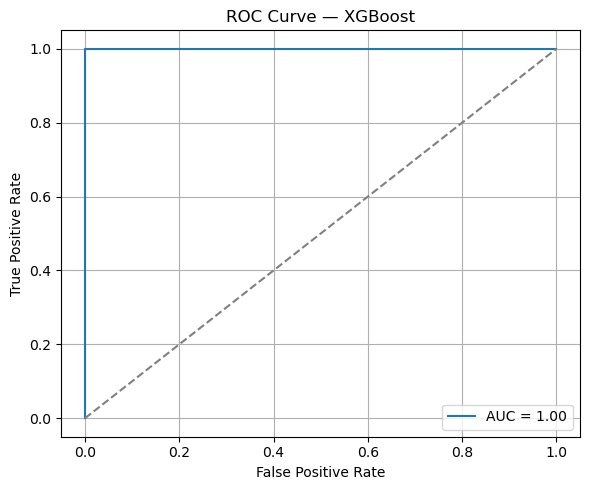

CV F1 scores (XGB): [1.         0.94736842 1.         0.97260274 0.99319728]
Mean F1 (XGB): 0.9826336879380447


In [2]:
# models/xgboost_flood.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump


from xgboost import XGBClassifier

#-----loading data -----
df = pd.read_csv("flood_model_lagged.csv", parse_dates=["date"])
X = df.drop(columns=["date", "flood"])
y = df["flood"].astype(int)


pos = y.sum()
neg = len(y) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight ≈ {scale_pos_weight:.2f} (neg={neg}, pos={pos})")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


xgb = XGBClassifier(
    random_state=42,
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight, 
)
xgb.fit(X_train, y_train)


y_pred  = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]


print("model XGBoost — Classification Report")
print(classification_report(y_test, y_pred, digits=2))


plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Flood", "Flood"],
    yticklabels=["No Flood", "Flood"]
)
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC (XGB): {roc_auc:.3f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend(loc="lower right"); plt.grid(True)
plt.tight_layout(); plt.show()


cv_scores = cross_val_score(xgb, X, y, cv=5, scoring="f1")
print("CV F1 scores (XGB):", cv_scores)
print("Mean F1 (XGB):", cv_scores.mean())

dump(xgb, "xgb_flood_model.pkl")
print("Saved: xgb_flood_model.pkl")
